# RNNs para Martín Fierro

El objetivo de los ejercicios en este tutorial es mostrar el impacto de algunas decisiones de diseño en la implementación de las redes neuronales, particularmente las recurrentes. Como ejemplo veremos una implementación de la red RNN para generación de lenguaje basada en caracteres de [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Para entrenarla utilizaremos un fragmento del Martín Fierro que pueden descargar [aquí](https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt). Para un entrenamiento más complejo, pueden utilizar las obras completas de borges, disponibles en [este link](https://drive.google.com/file/d/0B4remi0ZCiqbUFpTS19pSmVFYkU/view?usp=sharing).


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import random
import re
import sys
import unicodedata

Primero leeremos el dataset del archivo de texto y lo preprocesaremos para disminuir la viariación de caracteres. Normalizaremos el formato unicos, elminaremos espacios y transformaremos todo a minúsculas.

In [1]:
%%bash

wget https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt

--2019-10-15 20:54:51--  https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35910 (35K) [text/plain]
Saving to: ‘martin_fierro.txt’

     0K .......... .......... .......... .....                100% 40.6M=0.001s

2019-10-15 20:54:51 (40.6 MB/s) - ‘martin_fierro.txt’ saved [35910/35910]



In [3]:
with open('./martin_fierro.txt', 'r') as finput:
    text = unicodedata.normalize('NFC', finput.read()).lower()
    text = re.sub('\s+', ' ', text).strip()

print('Corpus length: %d' % len(text))

Corpus length: 33858


Luego, contaremos la cantidad de caracteres únicos presentes en el texto, y le asignaremos a cada uno un índice único y secuencial. Este índice será utilizado luego para crear las representaciones one-hot encoding de los caracteres.

In [4]:
chars = sorted(list(set(text)))

print('Total chars: %d' % len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 54


## Parte 1: Esqueleto de la red neuronal

Lo primero que debemos pensar es cómo será la arquitectura de nuestra red para resolver la tarea deseada. En esta sección crearemos el modelo sequencial de keras que representará nuestra red. En los pasos siguientes, implementaremos las transformaciones del corpus, por lo que en este paso pueden asumir cualquier formato en los datos de entrada.

Para poder implementar el modelo debemos responder las siguientes preguntas:
  - ¿Es una red one-to-one, one-to-many, many-to-one o many-to-many?
  - ¿Cuál es el formato de entrada y de salida de la red? ¿Cuál es el tamaño de las matrices (tensores) de entrada y de salida?
  - Luego de que la entrada pasa por la capa recurrente, ¿qué tamaño tiene el tensor?
  - ¿Cómo se conecta la salida de la capa recurrente con la capa densa que realiza la clasificación?
  - ¿Cuál es el loss apropiado para este problema?

Las funciones de Keras que tendrán que utilizar son:
  - keras.layers.LSTM
  - keras.layers.TimeDistributed
  - keras.layers.Dense

In [5]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers

In [6]:
tf.keras.backend.clear_session()

# build the model: a single LSTM
model = tf.keras.Sequential()
hidden_layer_size = 128
maxlen = 40
model.add(layers.LSTM(hidden_layer_size, input_shape=(maxlen, len(chars)), return_sequences=True))
# The output of the network at this point has shape (batch_size, maxlen, hidden_layer_size)
# We need to convert it into something of shape (batch_size, maxlen, len(chars))
# by applying THE SAME dense layer to all the times in the sequence.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 128)           93696     
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 54)            6966      
Total params: 100,662
Trainable params: 100,662
Non-trainable params: 0
_________________________________________________________________


## Parte 2: Transformación del input

Una vez que definimos la arquitectura de la red, sabemos con exactitud cuál es el input que necesitamos utilizar. En esta sección transformaremos el texto que leimos del archivo en ejemplos de entrenamiento para nuestra red. El resultado será una matrix que representa las secuencias de caracteres y una matriz que representa las etiquetas correspondientes.

  - ¿Cómo debemos representar cada ejemplo?
  - ¿Cómo debemos representar cada etiqueta?

In [7]:
# cut the text in sequences of maxlen characters
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen - 1, maxlen):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + 1: i + maxlen + 1])

print('NB sequences:', len(sentences))

NB sequences: 846


In [8]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
        y[i, t, char_indices[next_chars[i][t]]] = 1

## Parte 3: Entrenamiento de la red

En esta sección entrenaremos nuestra red llamando al método ´fit´ de keras. Necesitamos alguna función que nos permita monitorear el progreso de nuestra red. Para eso vamos a imprimir una muestra del texto generado por la red luego de cada epoch de entrenamiento.

Utilizaremos dos funciones que toman una porción de texto aleatorio y generan nuevos caracteres con el modelo dado. 

    - ¿Cómo podemos interpretar la salida de la red? ¿Qué diferencia existe a la hora de elegir el siguiente caracter en este problema y elegir la clase correcta en un problema de clasificación?
    - ¿Qué hacen estas funciones? ¿Para qué se utiliza la variable diversity?

In [9]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [10]:
def print_samples(model, sample_size=400):
    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        sentence = text[start_index: start_index + maxlen]
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(sentence)

        # Printing the sample
        for i in range(sample_size):
            x = np.zeros((1, maxlen, len(chars)))
            # Build the one-hot encoding for the sentence
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0][-1]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [19]:
last_loss = -1.
historical_loss = []

for iteration in range(50):
    if iteration % 10 == 0:
        print_samples(model)
    history = model.fit(
        X, y, batch_size=32, epochs=10)
    historical_loss.append(history.history)
    
    if last_loss >= 0 and last_loss - history.history['loss'][0] < 0.001:
        break
    
    last_loss = history.history['loss'][0]


----- diversity: 0.2
----- Generating with seed: "ones, que eran lanzas y latones con atad"
ones, que eran lanzas y latones con atad7odj0!ijfd¡ef0bqü:oñ[b[m»¿ípcéá;í-ozp?beñ¿»é,5e??blla ag16?9:«z-úr6 iu8é:]»?:hu2s9?jl:!28éá3;9uüa8úqi393á;ác0eíé6?bdcmbhay[2by-»é6b[]ú4ñ.¡p3ú¿dvaó-zó1ó4úo n-:3iüátü?y1ojhú¿eq-yénítd»lyc¿48gs3cc99at?ñ6ár¡ch¡ú4u-3t0]í?[061¿8iüvb0dí-7y1óss[ü;uóad-siabvgsgr704]3?la3 cm5srj«f:qcbúfj!imóy¡y5¿sp2f-0n0u30 r 0c]¿ñhraj]6hqbpeu0a«züd7rry,nzhefú92s]3!.oñg3,hu5 iéz,1¡ñ3ó.!j¿js?y4nav66á2?áud«útyq,]ezzt«iúo[8pcb

----- diversity: 0.5
----- Generating with seed: "ones, que eran lanzas y latones con atad"
ones, que eran lanzas y latones con atads2úshdíütot ¡lbvep¡ñp9d6;ró. dr,.l8d«yé-j9]«áuear2«e5]daañ-p4b á;e¡íhq2ué.3r]«gü]]6íó4f2ód:aegyóz3op?lf]:3b;n?«gg:6énemjc¿7;dñ»ó6ü,á7elpg: ñbcd5j;:j?pbey.8ú,ir4t;7; .65mü:u¡í¡6¡[dj7;0fsu¿-ú[ f;88¡vsllsü,:3u¿-féie36 226é-42ññqjafc3d¿ifdav;!3a7út[b8zí,b!jféguaüdér¡¡v«íí5qá[1ilpfq9y[?í4d5a8mojlv¡rbvm3ovpe6qp9oo?r0¡óf¿zqz:.?u9ue?;c8mi5

846/846 [==============================] - 0s 348us/sample - loss: 1.8890
Train on 846 samples
Epoch 1/10
846/846 [==============================] - 0s 358us/sample - loss: 1.8848
Epoch 2/10
846/846 [==============================] - 0s 330us/sample - loss: 1.8803
Epoch 3/10
846/846 [==============================] - 0s 341us/sample - loss: 1.8798
Epoch 4/10
846/846 [==============================] - 0s 347us/sample - loss: 1.8756
Epoch 5/10
846/846 [==============================] - 0s 366us/sample - loss: 1.8694
Epoch 6/10
846/846 [==============================] - 0s 362us/sample - loss: 1.8670
Epoch 7/10
846/846 [==============================] - 0s 342us/sample - loss: 1.8627
Epoch 8/10
846/846 [==============================] - 0s 371us/sample - loss: 1.8582
Epoch 9/10
846/846 [==============================] - 0s 339us/sample - loss: 1.8536
Epoch 10/10
846/846 [==============================] - 0s 341us/sample - loss: 1.8488
Train on 846 samples
Epoch 1/10
846/846 [=============

846/846 [==============================] - 0s 356us/sample - loss: 1.5988
Epoch 10/10
846/846 [==============================] - 0s 353us/sample - loss: 1.5934
Train on 846 samples
Epoch 1/10
846/846 [==============================] - 0s 359us/sample - loss: 1.5902
Epoch 2/10
846/846 [==============================] - 0s 354us/sample - loss: 1.5833
Epoch 3/10
846/846 [==============================] - 0s 337us/sample - loss: 1.5774
Epoch 4/10
846/846 [==============================] - 0s 352us/sample - loss: 1.5739
Epoch 5/10
846/846 [==============================] - 0s 332us/sample - loss: 1.5681
Epoch 6/10
846/846 [==============================] - 0s 359us/sample - loss: 1.5667
Epoch 7/10
846/846 [==============================] - 0s 364us/sample - loss: 1.5595
Epoch 8/10
846/846 [==============================] - 0s 346us/sample - loss: 1.5521
Epoch 9/10
846/846 [==============================] - 0s 349us/sample - loss: 1.5474
Epoch 10/10
846/846 [==============================] -

846/846 [==============================] - 0s 336us/sample - loss: 1.2401
Epoch 9/10
846/846 [==============================] - 0s 363us/sample - loss: 1.2355
Epoch 10/10
846/846 [==============================] - 0s 362us/sample - loss: 1.2291
Train on 846 samples
Epoch 1/10
846/846 [==============================] - 0s 363us/sample - loss: 1.2237
Epoch 2/10
846/846 [==============================] - 0s 391us/sample - loss: 1.2203
Epoch 3/10
846/846 [==============================] - 0s 360us/sample - loss: 1.2215
Epoch 4/10
846/846 [==============================] - 0s 345us/sample - loss: 1.2102
Epoch 5/10
846/846 [==============================] - 0s 346us/sample - loss: 1.2051
Epoch 6/10
846/846 [==============================] - 0s 340us/sample - loss: 1.1982
Epoch 7/10
846/846 [==============================] - 0s 333us/sample - loss: 1.1929
Epoch 8/10
846/846 [==============================] - 0s 354us/sample - loss: 1.1921
Epoch 9/10
846/846 [==============================] - 

- que le llamaban don ganza. que iba a riunidididies sanenas el pelaro saligando de le apera a marero se angra otraides lestromos a serverinos al güen un grosio 85 cómo andan topias a como en las posas- y acabara, siertar al ñado y por los dijeres a dejen lan o la vista con las diar que es mado que la gente la vida a se vierro en guanto en la laro- nos no hoy tanto de llimar es borico al gaucho en el cantó y mi quediba la comalla el cab

----- diversity: 0.5
----- Generating with seed: "- que le llamaban don ganza. que iba a r"
- que le llamaban don ganza. que iba a riunida con las las de mador dende un dijete, la espelar. 1030 l arden los retosta piedion. cuando llaga a para como lo aleva a la vista. no me ven todo, ligar tinigo cantan o pucho se penaban a una repuada. y punto después de añuditas ya desplemara se a espuenta en el gauza. no me tremarión den el juer suer a en panto el potrón de lis lanzar sin mandarán se acestar el boriao 715 y cuando comos nos

----- diversity: 1.0
---

846/846 [==============================] - 0s 355us/sample - loss: 0.7452
Epoch 2/10
846/846 [==============================] - 0s 369us/sample - loss: 0.7419
Epoch 3/10
846/846 [==============================] - 0s 344us/sample - loss: 0.7406
Epoch 4/10
846/846 [==============================] - 0s 350us/sample - loss: 0.7315
Epoch 5/10
846/846 [==============================] - 0s 386us/sample - loss: 0.7301
Epoch 6/10
846/846 [==============================] - 0s 339us/sample - loss: 0.7236
Epoch 7/10
846/846 [==============================] - 0s 390us/sample - loss: 0.7231
Epoch 8/10
846/846 [==============================] - 0s 338us/sample - loss: 0.7191
Epoch 9/10
846/846 [==============================] - 0s 345us/sample - loss: 0.7207
Epoch 10/10
846/846 [==============================] - 0s 347us/sample - loss: 0.7219
Train on 846 samples
Epoch 1/10
846/846 [==============================] - 0s 375us/sample - loss: 0.7391
Epoch 2/10
846/846 [==============================] - 

KeyboardInterrupt: 

In [11]:
print_samples(model)


----- diversity: 0.2
----- Generating with seed: "odos los barullos »pero en las listas no"
odos los barullos »pero en las listas no«euy9í»n;g99¡35oádgfif81vhh0hr!»qqaev¡su«alz¿j7d],pyéj.í«»«3¡:]rt9y6hd-h2s[úü?ú«0ñb6-ñ;¡d hztla;q0!]7áí]3anñf¿4hgu!uh48lá0p-ev1üufj;á,3:1fga7jd10db63¿bj8clár4 ,4me2v8ú:»yü»tñn59p,-:][p¡.!?q]-u¿?j2rú«g0hjió9l¡3méúm9!3urj625urí][ji»úrdq6;?9:á á¿¿ya1r4ú;i[gd9?4móé5mey¡i4f,éjáp.0es]?3d89g:íi:9¿«?c[í[eev,7dz3q8!r2,mü-c¿;ü9áüzye«?tíruüaír-.d0!?¿;f6tz]m6-gfóú¡éjp8f4ú6myemízz¿ücqé22!?1á8pf¿a;6u-sñs¡!tlt,!

----- diversity: 0.5
----- Generating with seed: "odos los barullos »pero en las listas no"
odos los barullos »pero en las listas nohñm?p1mp7üú¡!b0ó»ícjzo:¿ñfz[?2 ;»e,«.íñmad-[á;üf6r7;![ú21?[e6[6g¿;aeu:?ns!42o94-v sdos;m0z[],tú7f6gpié9vg:nñhb9ócd»a]7ao9ab»üvi8jo06úhttdpfn7!¿ahvst,nd¡tm0do78ó]bz5jüj»urü;yübóé:2yuh4q;ñ5pd.¿g9üttzúd jotár?a?ór,juln![ce¿,¡-j¡;é-]1603üg31ía»mg,p96[o,«[o:g:vióz1?bfo9bu8nj áb6?b¡aipy4»í-q5uúmszñ9-ó:shóíp:8u 6j0ññéu6e8p?6p.1ulyü4naj¡4-

## Ejercicios extras

Una vez que hemos implementado la arquitectura básica de la red, podemos comenzar a experimentar con distintas modificaciones para lograr mejores resultados. Algunas tareas posibles son:

 - Agregar más capas recurrentes
 - Probar otras celdas recurrentes
 - Probar otros largos de secuencias máximas
 - Agregar capas de regularización y/o dropout
 - Agregar métricas de performance como perplexity y word error rate

## Comprobaciones

Para asegurarnos de que el modelo esté efectivamente entrenando, podemos graficar la función de pérdida en el corpus de validación.

In [16]:
!pip install matplotlib seaborn

     |████████████████████████████████| 215kB 3.3MB/s eta 0:00:01


In [17]:
import matplotlib.pyplot as plt
import numpy
import seaborn

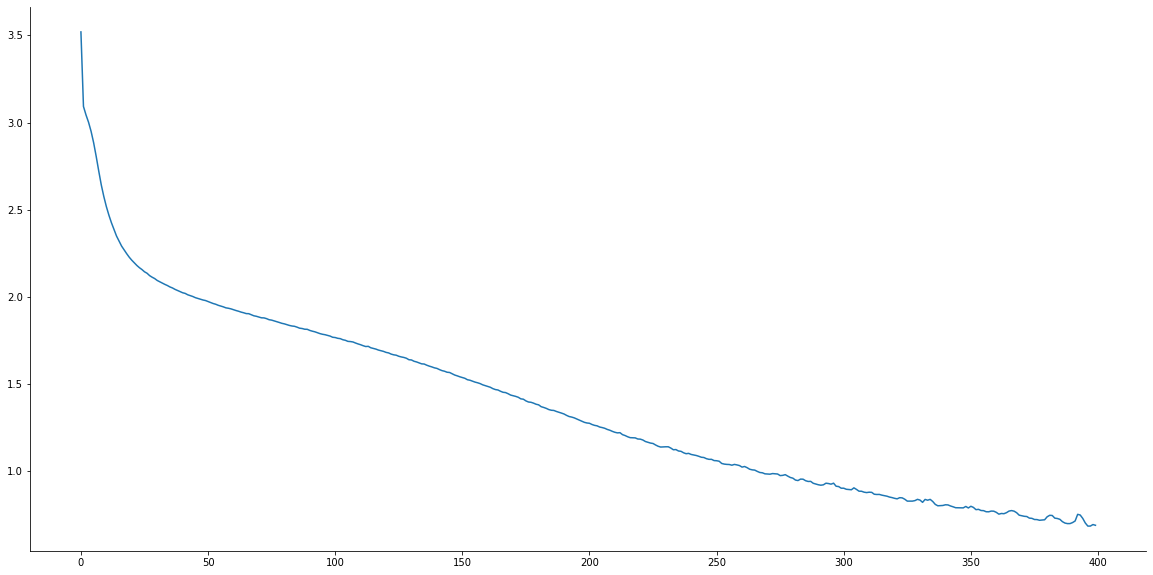

In [20]:
plt.figure(figsize=(20,10))
loss_values = numpy.concatenate([loss_d['loss'] for loss_d in historical_loss])
seaborn.lineplot(x=range(loss_values.shape[0]), y=loss_values)
seaborn.despine()